<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Loading and Plotting Data and Models

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Machine Learning in Python: a Hands-on Guide with Code". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, Applied Machine Learning in Python: a Hands-on Guide with Code, https://geostatsguy.github.io/MachineLearningDemos_Book. 
```

The workflows in this book and more are available here:

```{admonition} Cite the MachineLearningDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, MachineLearningDemos: Python Machine Learning Demonstration Workflows Repository (0.0.1). Zenodo. [![DOI](https://zenodo.org/badge/862519860.svg)](https://zenodo.org/doi/10.5281/zenodo.13835312)
```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Loading and Plotting Data and Models**. 

I cover loading data:

* **data tables** - $n \times m$ comma delimited files representing tabular data with the $n$ rows for samples and the $m$ columns for features. The feature may include various collocated measurements for multivariate datasets and may include location coordinates $x, y, z$ for spatial data. The feature names are assumed to be in the first row. The specific value denoting missing data (null values) should be explicitly specified.

* **gridded data** - $n_x \times n_y$ comma delimited files representing a regular grid of values for a single features, e.g., a map in space or a model predicting over a regular set of intervals for 2 predictor features. Multiple features usually requires one feature per file. 

For plotting I cover:

* **location maps** for plotting tabular spatial data, data points over locations or in feature space with one or more features shown as colors and or marker shapes. 
* **pixel plots** for plotting gridded, exhaustive spatial data and models with one or more features

**YouTube Lecture**: check out my lecture on [Displaying Data](https://youtu.be/TbqaMXdSV4I?si=UwGH-iRc7V962yNF), see the first part of this larger lecture on univariate distributions.

#### Load the Required Libraries

The following code loads the required libraries. We include GeostatsPy for some super compact, nice location map and pixel plot functions based on matplotlib.

In [3]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))        

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [5]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
import matplotlib as mpl                                      # custom colorbar
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

#### Define Functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

In [7]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Make Custom Colorbar

We make this colorbar to display our categorical, sand and shale facies.

* Custom color maps are a great way to improve our plots! We can easily modify color maps are make new ones like this.

In [9]:
cmap_facies = mpl.colors.ListedColormap(['grey','gold'])
cmap_facies.set_over('white'); cmap_facies.set_under('white')

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [11]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* X and Y coordinates ($m$)
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$)
* * facies 0 and 1 

In [13]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v13.csv") # load the data from Dr. Pyrcz's GitHub repository
df = df.iloc[:,1:8]                                           # remove a blank column from the data table
df.head()                                                     # preview the DataFrame

,X,Y,Por,Perm,AI,Facies
0,180.0,769.0,13.770949,446.436677,3445.418690,1.0
1,530.0,259.0,13.974270,216.593948,3159.935063,1.0
2,470.0,139.0,6.031127,0.000000,5799.299877,0.0
3,250.0,179.0,5.158305,129.285485,5656.422332,0.0
4,960.0,169.0,5.553232,370.191342,6354.235120,0.0


#### Set Metadata

There is always important metadata to include with our data that is essential for our workflows and our plots. For example:

* feature names, proper name for plotting and units

I like to compactly and consistently set and store my metadata to generalize and streamline my workflows.

* I can easily load a new dataset, update the metadata and rerun my workflow.
* I avoid hard coding my workflows by using elements from lists for my features and plot labels rather than the actual strings. It is easier to update this block below than every workflow step and plot!

In [15]:
Xname = ['X','Y','Por','Perm','AI','Facies']                  # specify the predictor features (x2) and response feature (x1)
Xmin = [0.0,0.0,0.0,0.0,2000.0,0];                            # set minimums and maximums for visualization 
Xmax = [1000.0,1000.0,25.0,1600.0,7500.0,1.0]                      
Xlabel = ['X','Y','Porosity','Permeability','Acoustic Impedance','Facies'] # specify the feature labels for plotting
Xunit = ['m','m','%','mD',r'$\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$','0 = shale, 1 = sand']
Xlabelunit = [f"{s1} ({s2})" for s1, s2 in zip(Xlabel, Xunit)]

#### Summary Statistics

Let's look at summary statistics for all the features.  

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,720.0,479.395833,289.337554,0.000000,225.000000,460.000000,730.000000,990.000000
Y,720.0,525.572222,268.797902,9.000000,325.000000,525.000000,749.000000,999.000000
Por,720.0,13.154504,4.921139,3.113721,8.140312,14.192083,16.852002,22.801310
Perm,720.0,462.242089,325.040727,0.000000,195.268277,453.089288,704.256901,1525.989345
AI,720.0,3915.972800,1292.243819,2555.187875,2974.530389,3224.863572,5381.452060,7400.229415
Facies,720.0,0.691667,0.462126,0.000000,0.000000,1.000000,1.000000,1.000000


#### Specify the Area of Interest / Grid and Feature Limits

Let's specify a reasonable extents for our grid and features:

* we do this so we have consistent plots for comparison.
  
We could use commands like this one to find the minimum value of coordinate like the X:
```python
df['X'].min()
```

* But, it is better to manually set the ranges for clean and clear plots. e.g. do you want your location map plot to go from 0.05887 to 998.24230 exactly? 

In [19]:
xlim = [0.0,1000.0]; ylim = [0,1000]                          # specify the spatial extents                     

#### Select a Feature

Let's select a feature to work with.

0. X
1. Y
2. Porosity
3. Permeability
4. Acoustic Impedance
5. Facies

In [21]:
ix = 0; iy = 1; i = 2                                         # location x, y and feature 

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [23]:
GSLIB.locmap                                                  # GeostatsPy's location map function

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Let's add the plotting parameters and make a location map plot.

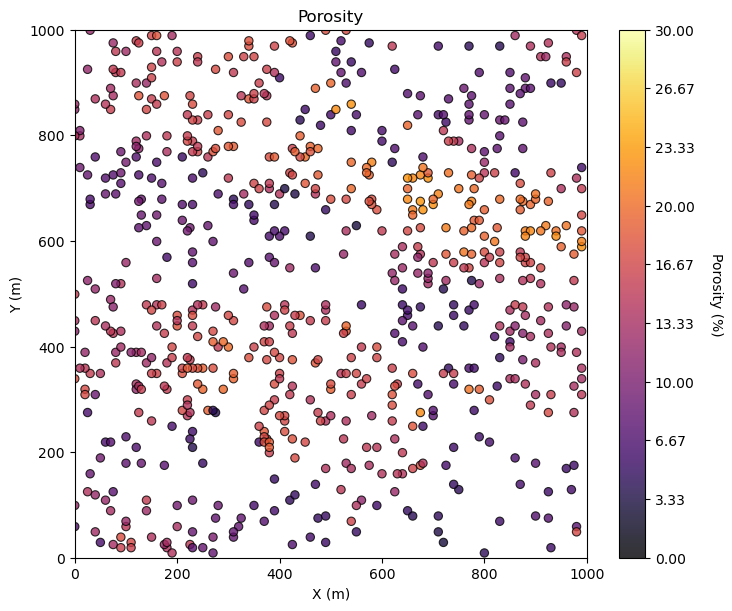

In [25]:
GSLIB.locmap_st(df,Xname[ix],Xname[iy],Xname[i],xlim[0],xlim[1],ylim[0],ylim[1],0.0,30.0,Xlabel[i],Xlabelunit[ix],Xlabelunit[iy],
             Xlabelunit[i],cmap)                              # location map plot
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

Maybe we can tighten up the color bar to see more details? and add some gridlines?

* we craft our data and model plots to best communicate to our audience. It's fun to make great data and model plots!

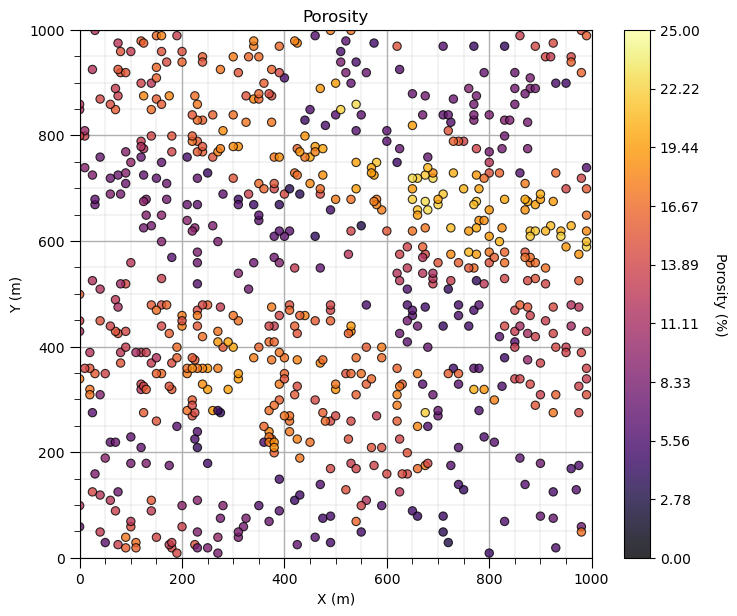

In [27]:
GSLIB.locmap_st(df,Xname[ix],Xname[iy],Xname[i],xlim[0],xlim[1],ylim[0],ylim[1],Xmin[i],Xmax[i],Xlabel[i],Xlabelunit[ix],Xlabelunit[iy],
             Xlabelunit[i],cmap); add_grid()                  # location map plot

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

Let's add the other properties into a composite figure with all the plots as subplots. 

* To do this we use the subplot command, in matplotlib package to prior to the figure command to indicate that the following figure is part of a subplot and we use subplots_adjust at the end to get the scaling right. 

* We can save our fancy figure to an image file with the file format and resolution that we need. 

This is great for writing reports, papers and making great looking update presentations. 

Note, in GeostatsPy, I provide additional plotting methods with and without '_st' in the name.

* with '_st' functions to 'stack' images in a composite figure. 
* without '_st' functions to produce a single image and simultaneously make a file

We can also just make a file after we make our composite plot, see below.

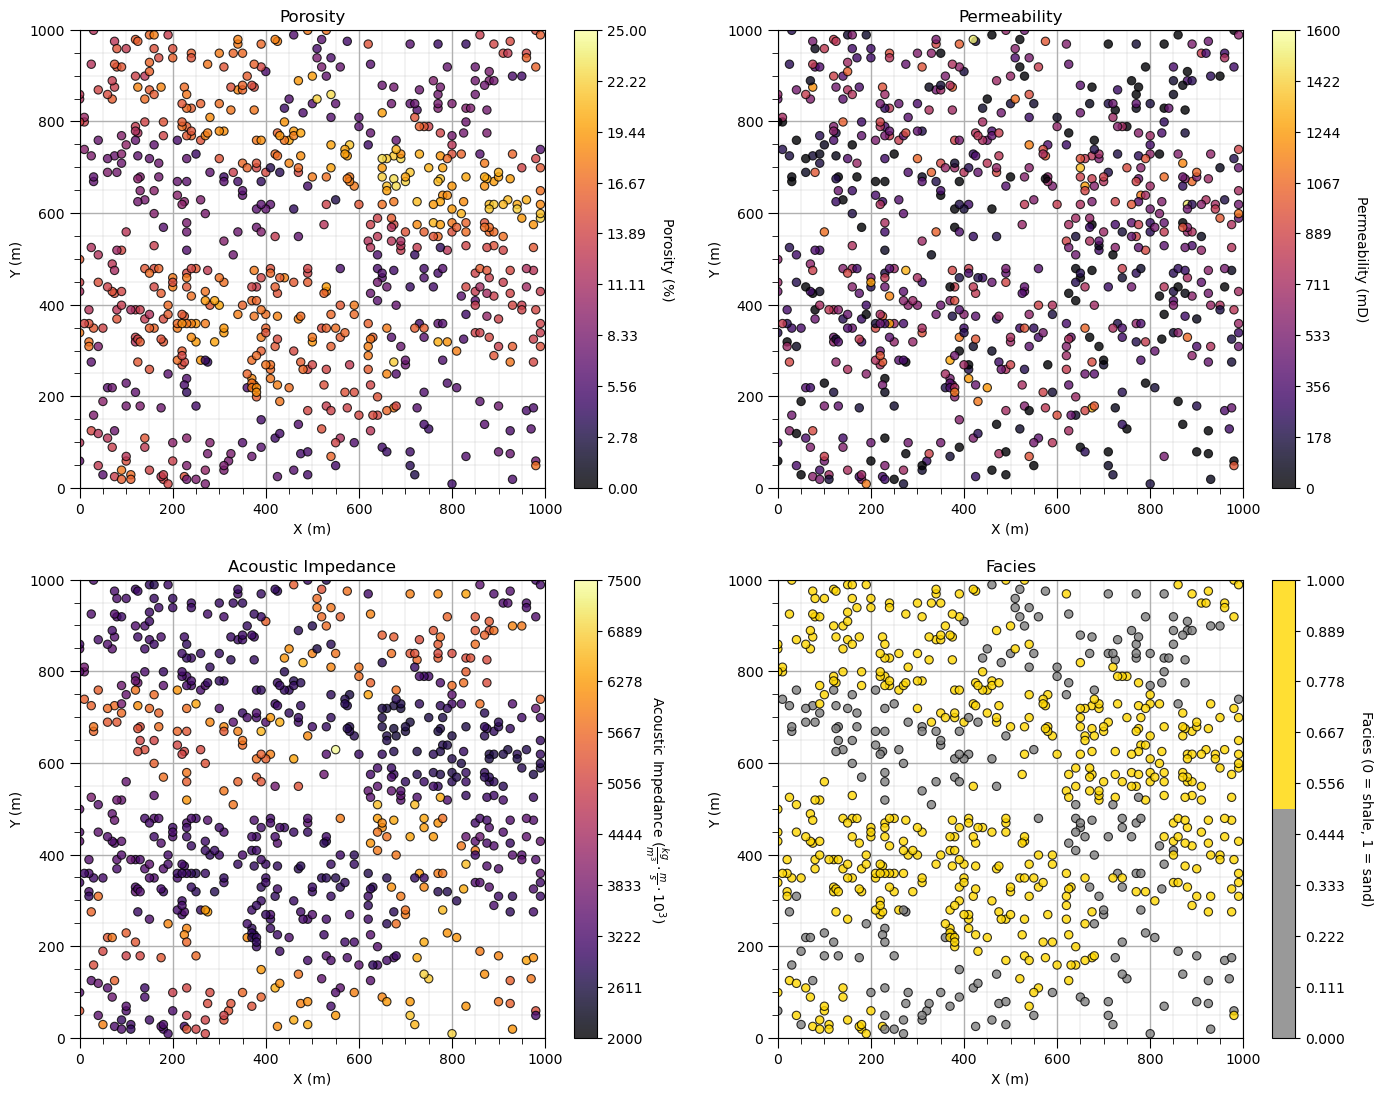

In [29]:
save_to_file = False                                          # save composite image to a file?

fimin = 2; fimax = 5                                          # index of features to plot, plotting 2, 3, 4, and 5 below

for i,fi in enumerate(range(fimin,fimax+1)):                  # loop over the subplots
    plt.subplot(2,2,i+1)
    if fi == 5: 
        lcmap = cmap_facies                                   # used facies colormap for facies, assumed to be index 5
    else: 
        lcmap = cmap
    GSLIB.locmap_st(df,Xname[ix],Xname[iy],Xname[fi],xlim[0],xlim[1],ylim[0],ylim[1],Xmin[fi],Xmax[fi],Xlabel[fi],Xlabelunit[ix],Xlabelunit[iy],
             Xlabelunit[fi],lcmap); add_grid()                # location map plot

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
if save_to_file == True:                                      # make a figure file
    plt.savefig('All_location_maps.tif',dpi=600,bbox_inches="tight")
plt.show()

Looks pretty good, eh? (yes, I am Canadian). 

* Did you notice the custom color map for facies? We could actually update the tick marks on the colorbar, this could be improved and will will address this shortly.

#### Location Maps with Matplotlib

Here's how you can make the same location map with Matplotlib.

* Once again, GeostatsPy is actually using Matplotlib for plotting and the plotting functions are for convenient, compact code.

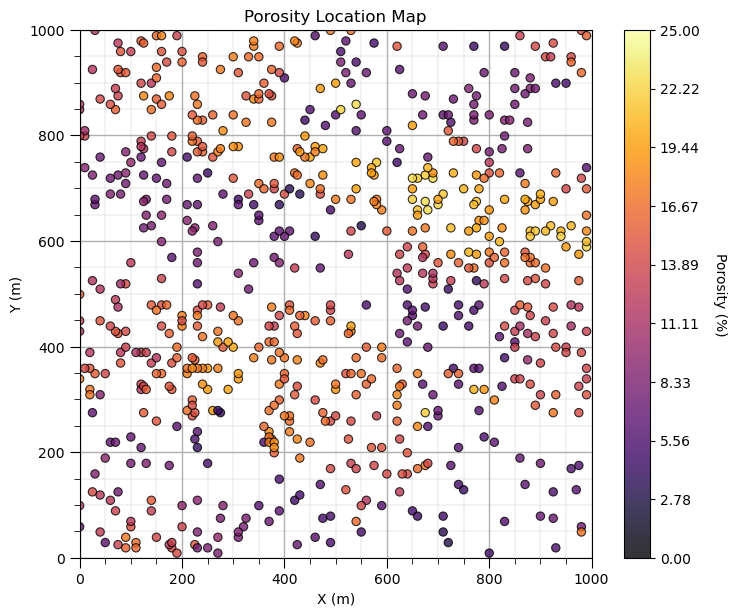

In [31]:
i = 2                                                       # select the feature for the location map
im = plt.scatter(df[Xname[ix]],df[Xname[iy]],s=None,c=df[Xname[i]],marker=None,cmap=cmap,norm=None,
        vmin=Xmin[i],vmax=Xmax[i],alpha=0.8,linewidths=0.8,edgecolors="black")
plt.title(str(Xlabel[i]) + ' Location Map')
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(Xlabelunit[ix]); plt.ylabel(Xlabelunit[iy])
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(Xmin[i],Xmax[i],10))
cbar.set_label(Xlabelunit[i], rotation=270, labelpad=20)
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Yes, I like to make location maps with 1 line of code and when we work directly with Matplotlib we write quite a few lines of code for a reasonable location map. Also, many folks are familiar with the parameterization of the locmap function from GSLIB, so I used the same parameters in my function in GeostatsPy.

Since we are making our own location map plot, let's repeat the facies location map and remove the colorbar and replace it with a legend. 

* this works quite well for categorical information
* if we just added a label to our feature, we only get one entry in the legend for all categories
* I wrote some code to find all the unique categories' integers from the categorical feature
* then I make 1 data point outside the plot area for each category to inform the legend

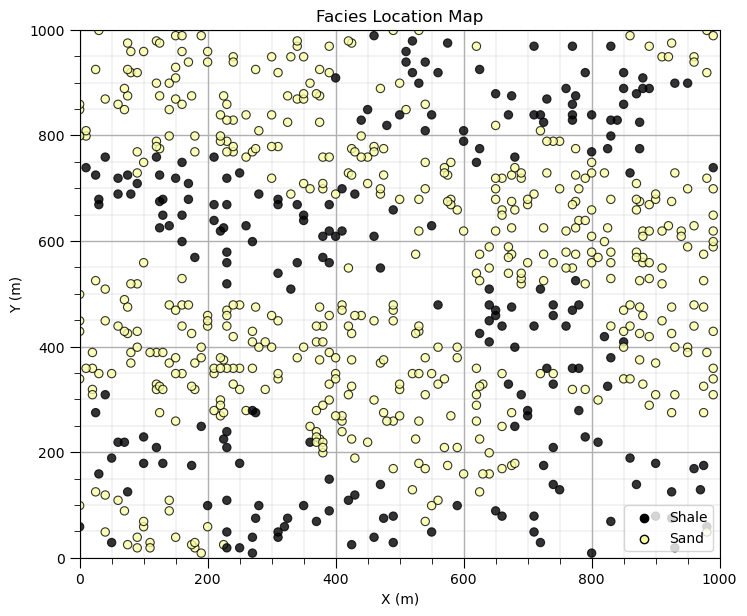

In [33]:
i = 5                                                         # select the facies feature

categories = np.unique(df[Xname[i]])                          # find the categorical indices             
cat_names = ['Shale','Sand']                                  # provide the category labels

im = plt.scatter(df[Xname[ix]],df[Xname[iy]],s=None,c=df[Xname[i]],marker=None,cmap=cmap,norm=None,
        vmin=Xmin[i],vmax=Xmax[i],alpha=0.8,linewidths=0.8,edgecolors="black") # location map plot
plt.title(str(Xlabel[i]) + ' Location Map')
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(Xlabelunit[ix]); plt.ylabel(Xlabelunit[iy])

for j,cat in enumerate(categories):                           # plot outside the plot area to inform the legend
    plt.scatter(xlim[0]-9999,ylim[0]-9999,marker='o',c = cat,edgecolor='black',label=cat_names[j],cmap=cmap,vmin=Xmin[i],vmax=Xmax[i])
plt.legend(loc = 'lower right')
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

That is enough customizing location maps for now. There is a lot we can do to customize and improve our plots with matplotlib. 

#### Loading Gridded Data

Let's load and visualize the gridded, exhaustive seismic data set.

* the data is a 2D map in X and Y, plan view.
* the data file is stored as an common delimited ASCII file.

The file looks like this.

3.499406970376157915e+03,3.485861232441123320e+03,3.358157676165383236e+03,3.212598229839397845e+03,2.969960100495822189e+03, $\dots$

The first row in file is the top y row ($iy = 0$) in the map. There are $ix = 1,\ldots,n_x$ values separated by comas and then a end of line. The next line of data is the row below the previous row ($iy = 1$) in this case and so forth. 

* NumPy arrays are indexed from top to bottom and left to right.
* In array notation, a location is denoted as:

````python
my2Darray[iy,ix]
````

Note, this is the opposite of many arrays that start at the bottom left corner (instead of top left corner) and order the indices ix,iy (instead of iy,ix).

Ok, we are ready to load our gridded seismic map data.

In [35]:
seismic = np.loadtxt("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v13_truth_AI.csv", 
                     delimiter=",")                           # load the 2D csv file

Once again, no errors, a good sign. Let's see what we loaded. 

In [37]:
type(seismic)                                                 # check the type of the load object

numpy.ndarray

It is an NumPy ndarray - an array of values. Good!  

Let's get more specific. We can use the 'type' command to find out what any object is and we can use the shape member of ndarray to get the size of the array (ny, nx).

In [39]:
print('The object type is ' + str(type(seismic)))              
print('  with size, ny =  ' + str(seismic.shape[0]) + ' and nx = ' + str(seismic.shape[1])) # check the grid size

The object type is <class 'numpy.ndarray'>
  with size, ny =  100 and nx = 100


#### Visualizing Gridded Data

We have a 100 cells in y and 100 cells in x grid but we need more information. 

* What is the origin, units, orientation and the cell size? 

This file format does not include that information so I'll give it to you. 

* cell size is 10m isotropic (same in x and y)

* grid goes from 0 to 1000m in x and y (origin is at 0,0) 

* grid orientation is aligned with x and y (Eastings and Northings, without any rotation).

We need to add the grid cell size, because we already have the grid extents (xmin, xmax, ymin and ymax) above.

In [41]:
csize = 10.0                                                  # grid cell size

We will use the pixelplt command reimplemented form GSLIB. To see the parameters type the name and run.

In [43]:
GSLIB.pixelplt                                                # GeostatsPy's pixel plot function

<function geostatspy.GSLIB.pixelplt(array, xmin, xmax, ymin, ymax, step, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

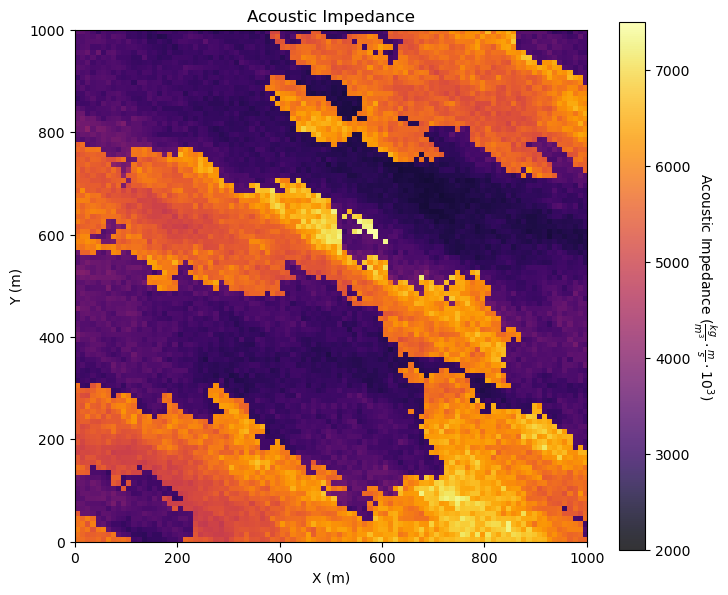

In [44]:
i = 4                                                         # we are working with AI, let's use our metadata from above
GSLIB.pixelplt_st(seismic,xlim[0],xlim[1],ylim[0],ylim[1],csize,Xmin[i],Xmax[i],Xlabel[i],Xlabelunit[ix],Xlabelunit[iy],
               Xlabelunit[i],cmap) # plot the seismic data
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Interesting, there are a lot of local variations in our subsurface unit in acoustic impedance. If acoustic impedance is well correlated to petrophysical properties then there is a lot of good information here.

#### Visualizing Tabular and Gridded Data Together

You may be concerned about the consistency between the tabular acoustic impedance samples and the gridded acoustic impedance.

* It is possible the data table was extracted from the gridded data or that there was a feature available or derived from the tabular data, regardless it is important that it is consistent.
* It is a good check to plot them together. 
* GeostatsPy's locpix is a function to plot tabular and gridded data together. 

In [46]:
GSLIB.locpix_st                                               # GeostatsPy's combined tabular and gridded data plot

<function geostatspy.GSLIB.locpix_st(array, xmin, xmax, ymin, ymax, step, vmin, vmax, df, xcol, ycol, vcol, title, xlabel, ylabel, vlabel, cmap)>

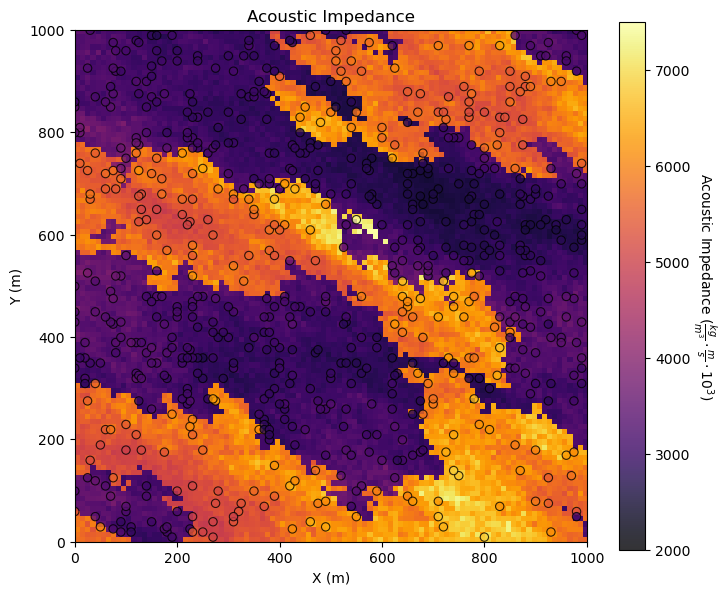

In [47]:
GSLIB.locpix_st(seismic,xlim[0],xlim[1],ylim[0],ylim[1],csize,Xmin[i],Xmax[i],df,Xname[ix],Xname[iy],Xname[i],Xlabel[i],Xlabelunit[ix],Xlabelunit[iy],
               Xlabelunit[i],cmap)                            # location map and pixel plot combined
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Other Ideas for Interrogating Spatial Data

Looks good. There is so much more that we can do to display our spatial data to learn form it. For example, what if we want to separate low and high porosity?  Try this, make a new property in the DataFrame with 0 for low porosity and 1 for high porosity.

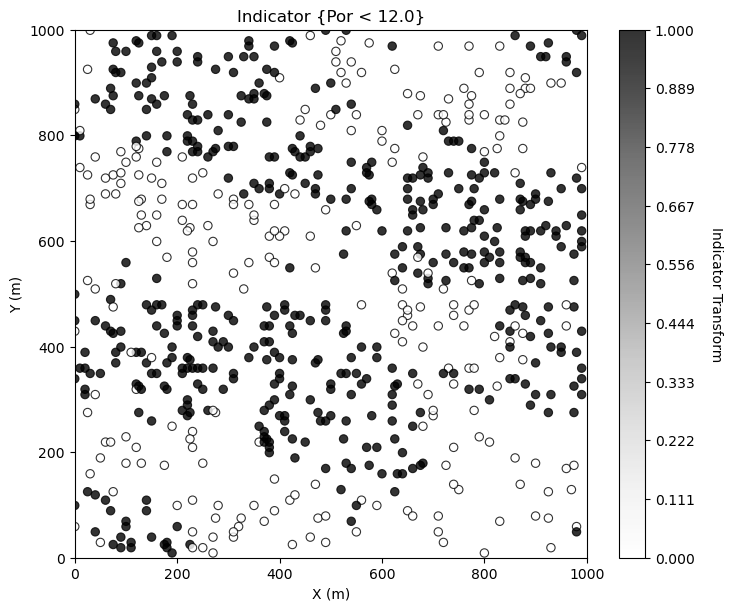

In [49]:
i = 2 ; threshold = 12.0                                      # select feature and threshold for indicator map

df['cat_'+ Xname[i]] = np.where(df[Xname[i]]>=threshold,1.0,0.0) # binary category assignment, 1 if > 12%, 0 otherwise

plt.subplot(111)
GSLIB.locmap_st(df,Xname[ix],Xname[iy],'cat_' + Xname[i],xlim[0],xlim[1],ylim[0],ylim[1],0.0,1.0, # location map plot
             'Indicator {' + Xname[i] + ' < ' + str(threshold) + '}',Xlabelunit[ix],Xlabelunit[iy],'Indicator Transform',cmap=plt.cm.Greys)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Making Your Own Plots from Scratch

Sometimes I make my custom plots from scratch actually working with lines, shapes and text! If you want to see some of my examples check out:

* [Principal Component Loadings](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_PCA_Eigen.ipynb) - for the interactive PCA principal component dashboard I made the component loading display in the lower right.

* [Bayesian Updating](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Bayesian_Updating.ipynb) - I wrote out the Bayesian updating equation, added interactive labels and a line plot with prior, likelihood and posterior on probability axis.

I actually do this often to maximize the creativity in my data and model plotting for great communication. 

#### Comments

I hope you found this chapter helpful. I hope you found this chapter useful. Much more could be done and discussed, I have many more resources. Check out my [shared resource inventory](https://michaelpyrcz.com/my-resources),

*Michael*

#### The Author:


Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)